In [1]:
%load_ext autoreload

In [2]:
from collections import defaultdict
from torch_ham.lagrangians import lagr_softmax
from torch_ham.neurons import IdentityNeuron, SoftmaxNeuron
from torch_ham.synapses import ConvSynapse, GenericSynapse, HopfieldSynapse, HopfieldWeight
from torch_ham.utils import conv_kernel_from_dim
from torch_ham import HAM
from tqdm.auto import tqdm
from typing import *

import copy
import gc
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = torch.device('cuda')
dtype = torch.float32

data_path = os.path.expanduser('~/data/compass.jld2')
compass = torch.tensor(np.array(h5py.File(data_path)['v']), device=torch.device('cpu'), dtype=dtype)
compass = torch.permute(compass, (2, 1, 0))
compass = compass-torch.min(compass)
compass = compass/torch.max(compass)

s = 2
compass = compass[::s,::s,::s]
nx, ny, nz = compass.shape
print(nx, ny, nz)

319 455 171


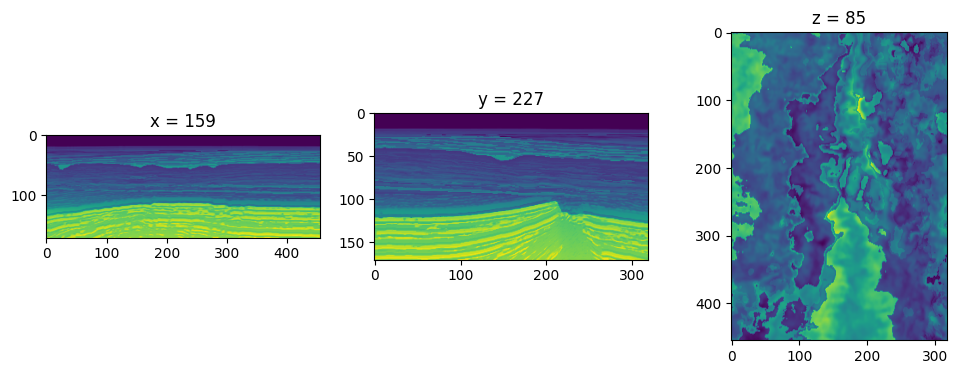

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(compass[nx//2,:,:].T)
plt.title(f'x = {nx//2}')
plt.subplot(132)
plt.title(f'y = {ny//2}')
plt.imshow(compass[:,ny//2,:].T)
plt.subplot(133)
plt.title(f'z = {nz//2}')
plt.imshow(compass[:,:,nz//2].T)

In [14]:
def ConditionalUNet(input_shape: Tuple[int],
                    condition_shape: Tuple[int],
                    kernel_size: Tuple[int],
                    downsample_size: Tuple[int],
                    depth: int,
                    in_channels: int = 1,
                    channel_scale: int = 1,
                    lagrangian: Callable = lagr_softmax,
                    device: torch.device = torch.device('cuda'),
                    dtype: torch.dtype = torch.float32) -> None:
    
    current_shape = copy.copy(input_shape)
    current_channels = in_channels
    
    neurons = {}
    synapses = {}
    connections = {}
    transforms = defaultdict(lambda: nn.Identity())
    
    neurons['c'] = IdentityNeuron(shape=condition_shape)
    
    for i in range(depth):
        
        # Neuron for current U-net scale
        neurons[f'n{i}'] = IdentityNeuron(shape=(current_channels, *current_shape))
        
        # Memory at current scale
        conv = conv_kernel_from_dim(len(current_shape))
        #synapses[f's{i}'] = HopfieldSynapse(
        #    conv(
        #        current_channels,
        #        current_channels,
        #        kernel_size=kernel_size,
        #        padding='same',
        #        device=device,
        #        dtype=dtype
        #    ),
        #    lagrangian=lagr_softmax,
        #    beta=0.1,
        #    dim=1
        #)
        #connections[f's{i}'] = [f'n{i}']
        # Connection between conditioning variable and neuron. Un-normalized
        # hopfield weight corresponds to rhs matrix multiply
        synapses[f'sc_{i}'] = GenericSynapse(
            nn.Linear(condition_shape[-1], np.prod([current_channels, *current_shape[:-1]]), bias=False, device=device, dtype=dtype),
            HopfieldWeight(current_shape[-1], condition_shape[0], normalize=False, device=device, dtype=dtype)
        )
        connections[f'sc_{i}'] = ['c', f'n{i}']
        transforms[(f'sc_{i}', f'n{i}')] = nn.Flatten(start_dim=1, end_dim=-2)
        
        if i < depth-1:
            # Connections between U-net scales
            synapses[f's{i}_{i+1}_down'] = ConvSynapse(
                current_channels,
                current_channels*channel_scale,
                kernel_size=downsample_size,
                stride=downsample_size,
                bias=False,
                device=device,
                dtype=dtype
            )
            connections[f's{i}_{i+1}_down'] = [f'n{i}', f'n{i+1}']
            
            output_padding = tuple(s%d for s, d in zip(current_shape, downsample_size))
            
            synapses[f's{i}_{i+1}_up'] = ConvSynapse(
                current_channels,
                current_channels*channel_scale,
                kernel_size=downsample_size,
                stride=downsample_size,
                output_padding=output_padding,
                bias=False,
                transpose=True,
                device=device,
                dtype=dtype
            )
            connections[f's{i}_{i+1}_up'] = [f'n{i}', f'n{i+1}']
            
            # Weight tying
            synapses[f's{i}_{i+1}_up'].f1.weight = nn.Parameter(synapses[f's{i}_{i+1}_down'].f0.weight)
            
            current_shape = tuple(s//d for s, d in zip(current_shape, downsample_size))
            current_channels *= channel_scale
            
    return HAM(
        neurons,
        synapses,
        connections,
        transforms
    )
            

In [15]:
# Number of wells to observe
n_wells = 4

# Depth of U-Net
depth = 5

model = ConditionalUNet(
    input_shape=(nx, nz),
    condition_shape=(nz, n_wells),
    kernel_size=(8, 8),
    downsample_size=(2, 2),
    depth=depth,
    in_channels=1,
    channel_scale=2
)

print(f'#params = {sum(p.numel() for p in model.parameters())}')

#params = 63895


In [16]:
# Setup optimization
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
batch_size = 5
n_examples = 1000
n_batches = n_examples // batch_size

alpha = 0.1
nt = depth

# Compute well locations
well_stride = nx//(n_wells+1)
well_idxs = torch.arange(well_stride//2, well_stride//2 + well_stride*n_wells, well_stride)

In [17]:
# Main loop
pbar = tqdm(range(n_batches))
for i in pbar:
    
    # Get random slices in x direction
    slice_idxs = torch.tensor(np.random.randint(0, ny, size=batch_size), dtype=torch.long)
    slices = torch.index_select(compass, dim=1, index=slice_idxs).transpose(0, 1)
    
    # Get well observations
    wells = torch.index_select(slices, dim=1, index=well_idxs).transpose(1, 2)
    
    # Move to device
    slices = slices.to(device)
    
    # Initialize model state
    states = model.init_states(
        batch_size=batch_size,
        exclude={'c'},
        requires_grad=True,
        device=device,
        dtype=dtype
    )
    
    # Set condition state
    states['c'] = wells.to(device).requires_grad_(True)
    
    # Run energy descent, fixing the condition
    for i in range(nt):
        activations = model.activations(states)
        grads = model.grads(states, activations)
        states = model.step(states, grads, alpha, pin={'c'})
    
    # Compute mse loss vs activations
    activations = model.activations(states)
    img = activations['n0'].squeeze(1)
    loss = F.mse_loss(img, slices)
    
    # Backprop
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    pbar.set_description(f'loss = {loss.item():2.8f}')

  0%|          | 0/200 [00:00<?, ?it/s]

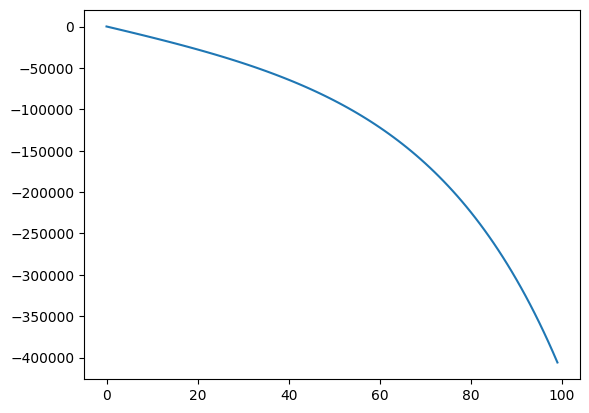

In [19]:
%autoreload

# Get random slices in x direction
slices = compass[:,390,:].unsqueeze(0)
wells = torch.index_select(slices, dim=1, index=well_idxs).transpose(1, 2)

# Move to device
slices = slices.to(device)

# Initialize model state
states = model.init_states(
    batch_size=1,
    exclude={'c'},
    requires_grad=True,
    device=device,
    dtype=dtype
)

# Set condition state
states['c'] = wells.to(device).requires_grad_(True)

# Run energy descent, fixing the condition
energies = []
for i in range(100):
    activations = model.activations(states)
    energies.append(model.energy(states, activations).item())
    grads = model.grads(states, activations, create_graph=False)
    states = model.step(states, grads, alpha=0.001, pin={'c'})
    
plt.plot(energies)

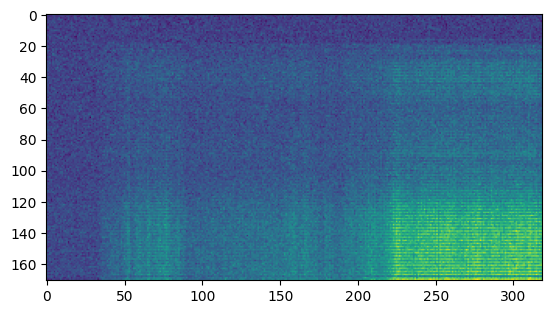

In [20]:
activations = model.activations(states)
img = activations['n0'].detach().cpu().squeeze()
plt.imshow(img.T)